In [1]:
!git clone https://github.com/sakshamjainwin/data_reconstruction_acdc.git

Cloning into 'data_reconstruction_acdc'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 128 (delta 7), reused 41 (delta 7), pack-reused 84 (from 1)
Receiving objects: 100% (128/128), 157.68 MiB | 33.00 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (73/73), done.


In [2]:
!pip install kornia
!pip install settings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement settings (from versions: none)
ERROR: No matching distribution found for settings


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/dataset_reconstruction')

In [46]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from import_for_notebooks import *
torch.set_default_dtype(torch.float64)

import common_utils
import analysis
import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric
from argparse import Namespace
args = Namespace()

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [78]:
import torch
# Get original digit labels for training data to filter for digit 0
from problems.mnist_odd_even import fetch_mnist, create_labels

# Load original MNIST data with original digit labels
dataset = fetch_mnist("/content/dataset_reconstruction/data", train=True, transform=torchvision.transforms.ToTensor())

# Get the mapping of training samples to original digits
# Since Xtrn was loaded with balanced odd/even samples from first 50000 training samples,
# we need to map back to original digits
digit_labels_full = torch.tensor([int(dataset[i][1]) for i in range(len(dataset))])

# Create mask for digit 0
digit_0_mask = digit_labels_full == 0
digit_0_indices = torch.where(digit_0_mask)[0]

print(f"Total digit 0 samples in MNIST: {digit_0_indices.shape[0]}")

Total digit 0 samples in MNIST: 5923


### Original Model

In [88]:
sweep = common_utils.common.load_dict_to_obj("/content/dataset_reconstruction/reconstructions/mnist_odd_even/sweep.txt")

args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: /content/dataset_reconstruction/runs/2026_02_14_01_36_42_886198_mnist_odd_even_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='/content/dataset_reconstruction/models/weights-mnist_odd_even_d250_mnist_odd_even.pth', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='mnist_odd_even', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_

Showing 50 reconstructions that match with digit 0 training samples
CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([80, 1, 28, 28]) 4


  0%|          | 0/1 [00:00<?, ?it/s]

0 0 80


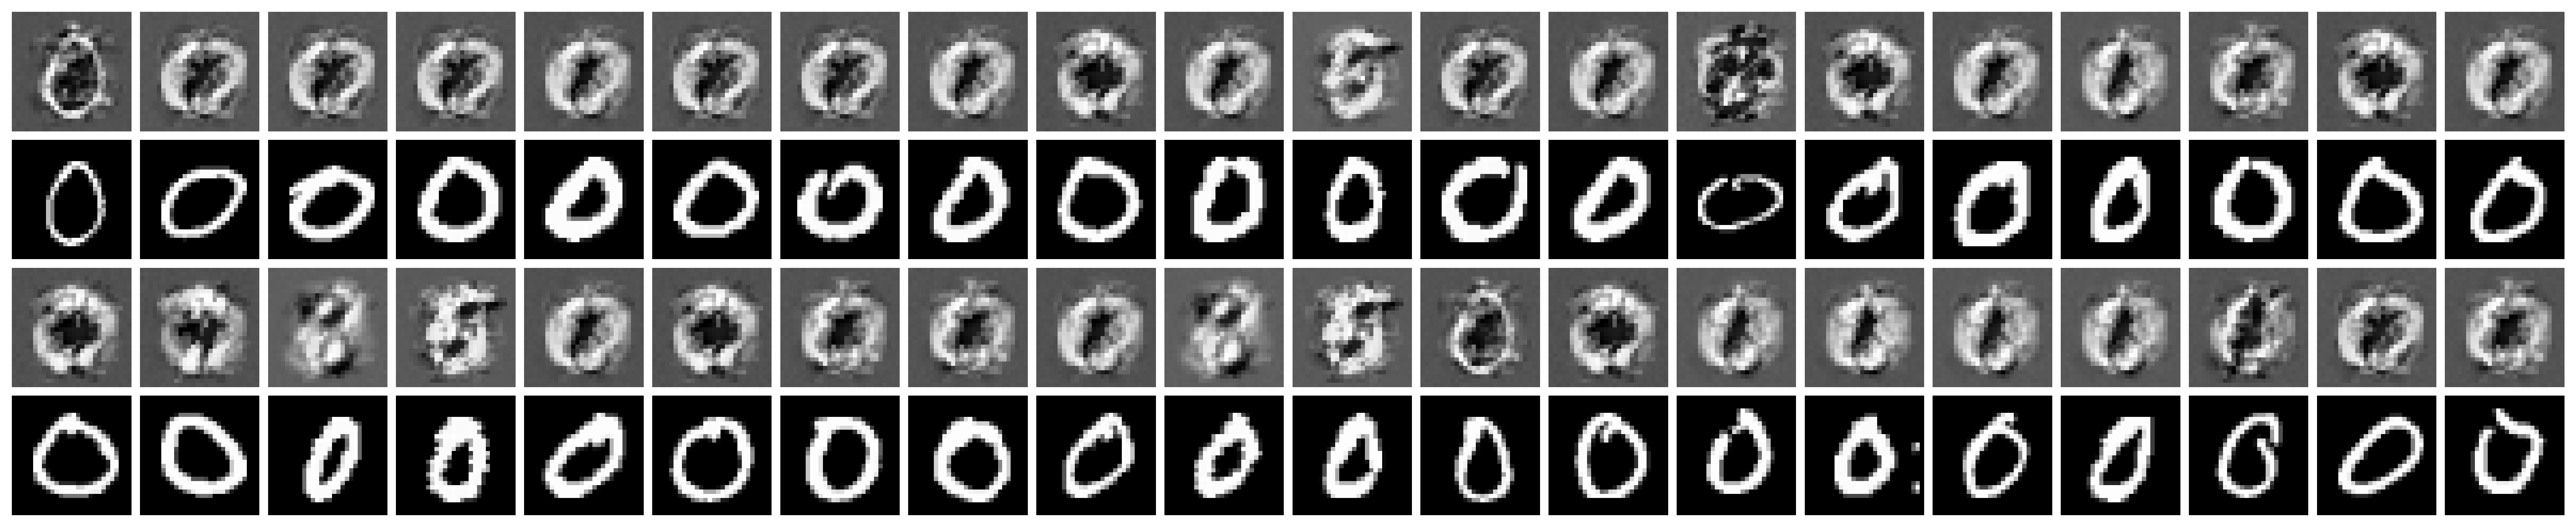

DONE!
tensor(896.1558, device='cuda:0', grad_fn=<SumBackward0>)


In [94]:
x_paths = [
    '/content/dataset_reconstruction/reconstructions/mnist_odd_even/rbijxft7_x.pth',
]
X = torch.load(x_paths[0])

# Find "Good" Reconstructions (as detailed in Appendix B.3) - DIGIT 0 ONLY:

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Filter for digit 0 only
# yy contains indices into Xtrn, we need to filter to keep only those that correspond to digit 0
# Align device
digit_0_indices = digit_0_indices.to(sort_idxs.device)

digit_0_in_Xtrn = torch.isin(sort_idxs, digit_0_indices)

xx = xx[digit_0_in_Xtrn]
yy = yy[digit_0_in_Xtrn]
ssims = ssims[digit_0_in_Xtrn]
sort_idxs = sort_idxs[digit_0_in_Xtrn]


print(f"Showing {len(xx)} reconstructions that match with digit 0 training samples")

values = model(Xtrn).data

# Plot
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=20, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)
print(torch.sum(model.layers[1].weight))

RECONSTRUCTION REPORT: DIGIT 0
Total Matches Found:      50
Unique Samples Recovered: 50
Redundancy Ratio:         1.00
------------------------------
Mean SSIM (All 50):       0.0736
Mean SSIM (Top 5):        0.0636

Visualizing Top 5 Reconstructions (Best to Worst):


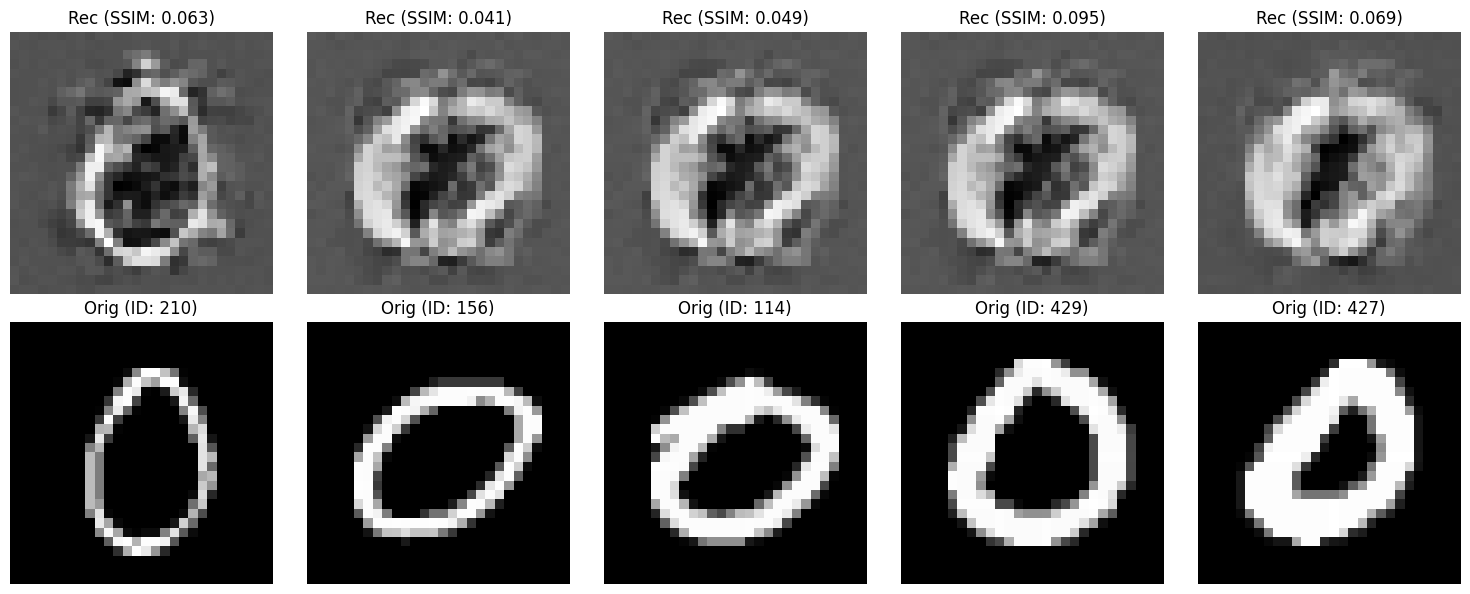

In [95]:
import torch
import matplotlib.pyplot as plt

# 1. Basic Counts
total_filtered = len(xx)
unique_indices = torch.unique(sort_idxs)
unique_count = len(unique_indices)
redundancy = total_filtered / unique_count if unique_count > 0 else 0

# 2. SSIM Metrics
# Since sort_by_metric was called with sort='ssim',
# the tensors are already ordered from highest SSIM to lowest.
mean_ssim_all = ssims.mean().item()
top_5_ssim = ssims[:5].mean().item()

# 3. Print the Report
print("="*30)
print("RECONSTRUCTION REPORT: DIGIT 0")
print("="*30)
print(f"Total Matches Found:      {total_filtered}")
print(f"Unique Samples Recovered: {unique_count}")
print(f"Redundancy Ratio:         {redundancy:.2f}")
print("-" * 30)
print(f"Mean SSIM (All 50):       {mean_ssim_all:.4f}")
print(f"Mean SSIM (Top 5):        {top_5_ssim:.4f}")
print("="*30)

# 4. Plotting the Top 5 specifically
print("\nVisualizing Top 5 Reconstructions (Best to Worst):")
plt.figure(figsize=(15, 6))
for i in range(5):
    # Top Row: Reconstructed
    plt.subplot(2, 5, i + 1)
    plt.imshow(xx[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Rec (SSIM: {ssims[i]:.3f})")
    plt.axis('off')

    # Bottom Row: Original Training Match
    plt.subplot(2, 5, i + 6)
    plt.imshow(yy[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Orig (ID: {sort_idxs[i].item()})")
    plt.axis('off')

plt.tight_layout()
plt.show()

Showing 50 reconstructions that match with digit 0 training samples
CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([80, 1, 28, 28]) 4


  0%|          | 0/1 [00:00<?, ?it/s]

0 0 80


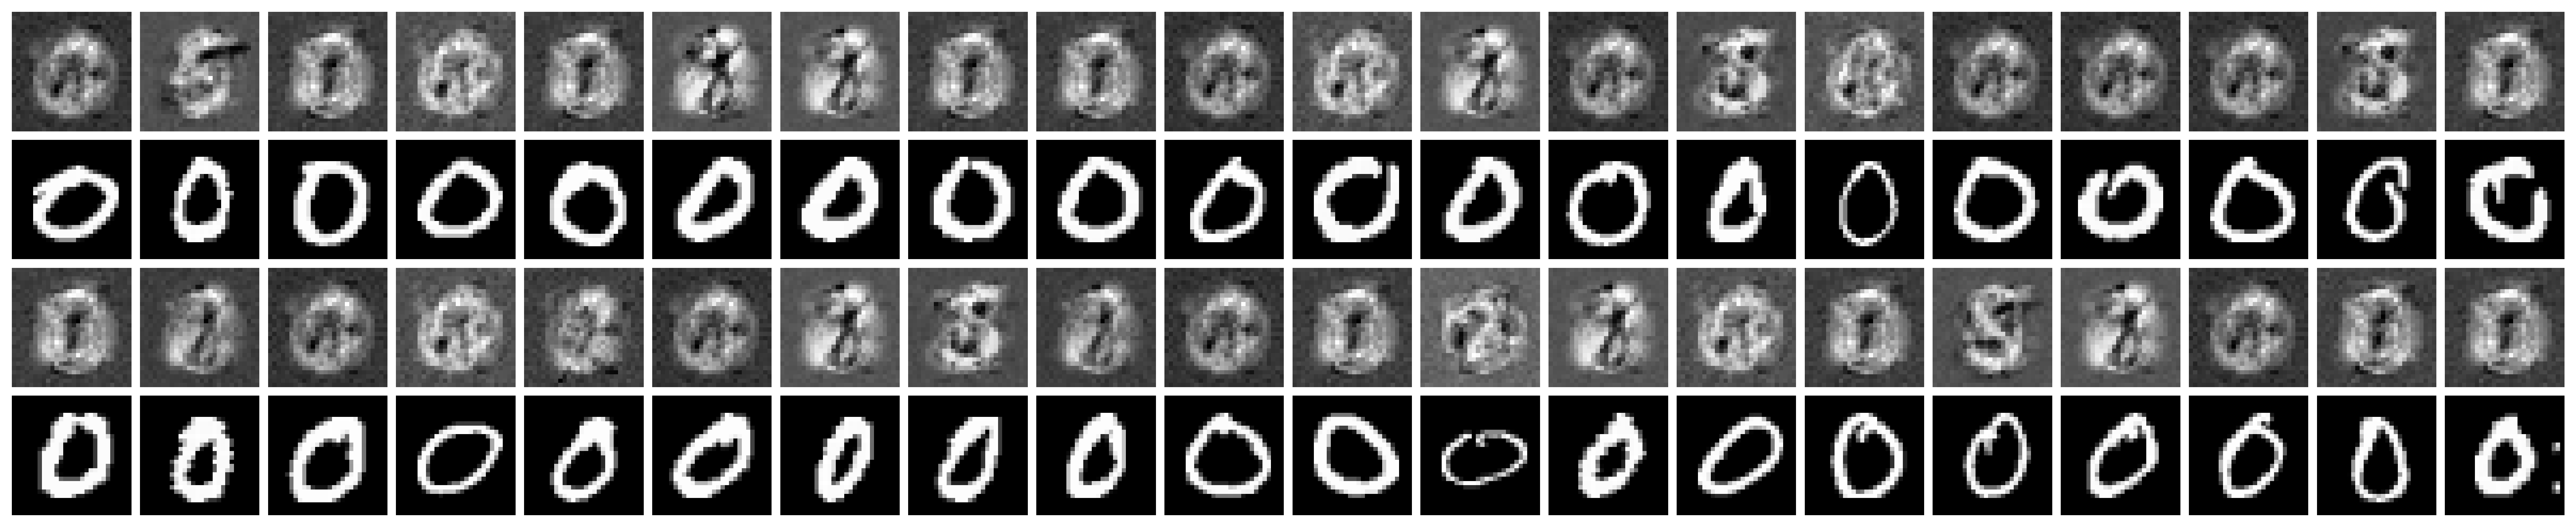

DONE!


In [107]:
x_paths = [
    '/content/dataset_reconstruction/reconstructions/mnist_odd_even/kcf9bhbi_x.pth',
]
X = torch.load(x_paths[0])

# Find "Good" Reconstructions (as detailed in Appendix B.3) - DIGIT 0 ONLY:

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Filter for digit 0 only
# yy contains indices into Xtrn, we need to filter to keep only those that correspond to digit 0
# Align device
digit_0_indices = digit_0_indices.to(sort_idxs.device)

digit_0_in_Xtrn = torch.isin(sort_idxs, digit_0_indices)

xx = xx[digit_0_in_Xtrn]
yy = yy[digit_0_in_Xtrn]
ssims = ssims[digit_0_in_Xtrn]
sort_idxs = sort_idxs[digit_0_in_Xtrn]


print(f"Showing {len(xx)} reconstructions that match with digit 0 training samples")

values = model(Xtrn).data

# Plot
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=20, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

RECONSTRUCTION REPORT: DIGIT 0
Total Matches Found:      50
Unique Samples Recovered: 50
Redundancy Ratio:         1.00
------------------------------
Mean SSIM (All 50):       0.0723
Mean SSIM (Top 5):        0.0449

Visualizing Top 5 Reconstructions (Best to Worst):


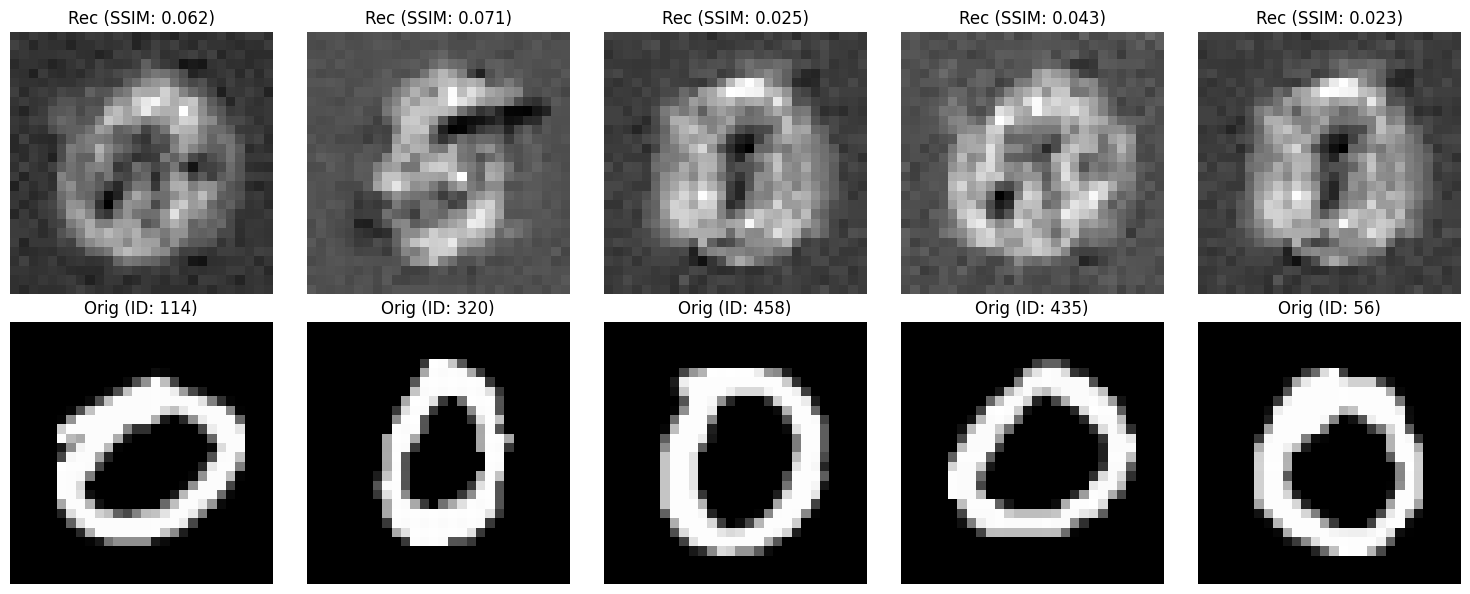

In [108]:
import torch
import matplotlib.pyplot as plt

# 1. Basic Counts
total_filtered = len(xx)
unique_indices = torch.unique(sort_idxs)
unique_count = len(unique_indices)
redundancy = total_filtered / unique_count if unique_count > 0 else 0

# 2. SSIM Metrics
# Since sort_by_metric was called with sort='ssim',
# the tensors are already ordered from highest SSIM to lowest.
mean_ssim_all = ssims.mean().item()
top_5_ssim = ssims[:5].mean().item()

# 3. Print the Report
print("="*30)
print("RECONSTRUCTION REPORT: DIGIT 0")
print("="*30)
print(f"Total Matches Found:      {total_filtered}")
print(f"Unique Samples Recovered: {unique_count}")
print(f"Redundancy Ratio:         {redundancy:.2f}")
print("-" * 30)
print(f"Mean SSIM (All 50):       {mean_ssim_all:.4f}")
print(f"Mean SSIM (Top 5):        {top_5_ssim:.4f}")
print("="*30)

# 4. Plotting the Top 5 specifically
print("\nVisualizing Top 5 Reconstructions (Best to Worst):")
plt.figure(figsize=(15, 6))
for i in range(5):
    # Top Row: Reconstructed
    plt.subplot(2, 5, i + 1)
    plt.imshow(xx[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Rec (SSIM: {ssims[i]:.3f})")
    plt.axis('off')

    # Bottom Row: Original Training Match
    plt.subplot(2, 5, i + 6)
    plt.imshow(yy[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Orig (ID: {sort_idxs[i].item()})")
    plt.axis('off')

plt.tight_layout()
plt.show()

### ACDC Model

In [79]:
sweep = common_utils.common.load_dict_to_obj("/content/dataset_reconstruction/reconstructions/mnist_odd_even/sweep_acdc.txt")

args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: /content/dataset_reconstruction/runs/2026_02_14_00_28_48_885516_mnist_odd_even_d250
Namespace(cuda=True, seed=1, proj_name='', precision='double', run_mode='reconstruct', pretrained_model_path='/content/dataset_reconstruction/models/mnist_0_baked.pt', train_save_model=True, train_save_model_every=-1, extract_save_results=True, extract_save_results_every=10000, save_args_files=True, wandb_active=False, wandb_project_name='Dataset_Extraction', wandb_entity='dataset_extraction', problem='mnist_odd_even', data_per_class_train=250, data_per_class_val=0, data_per_class_test=1000, data_reduce_mean=True, model_type='mlp', model_hidden_list=[1000, 1000], model_use_bias=False, use_init_scale=True, use_init_scale_only_first=True, model_init_list=[0.001, 0.001], model_train_activation='relu', train_epochs=1000, train_lr=0.01, train_evaluate_rate=1000, train_threshold=1e-40, train_SGD=False, train_SGD_batch_size=64, extraction_epochs=50000, extraction_data_amount_per_class=500, extracti

Showing 50 reconstructions that match with digit 0 training samples
CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([80, 1, 28, 28]) 4


  0%|          | 0/1 [00:00<?, ?it/s]

0 0 80


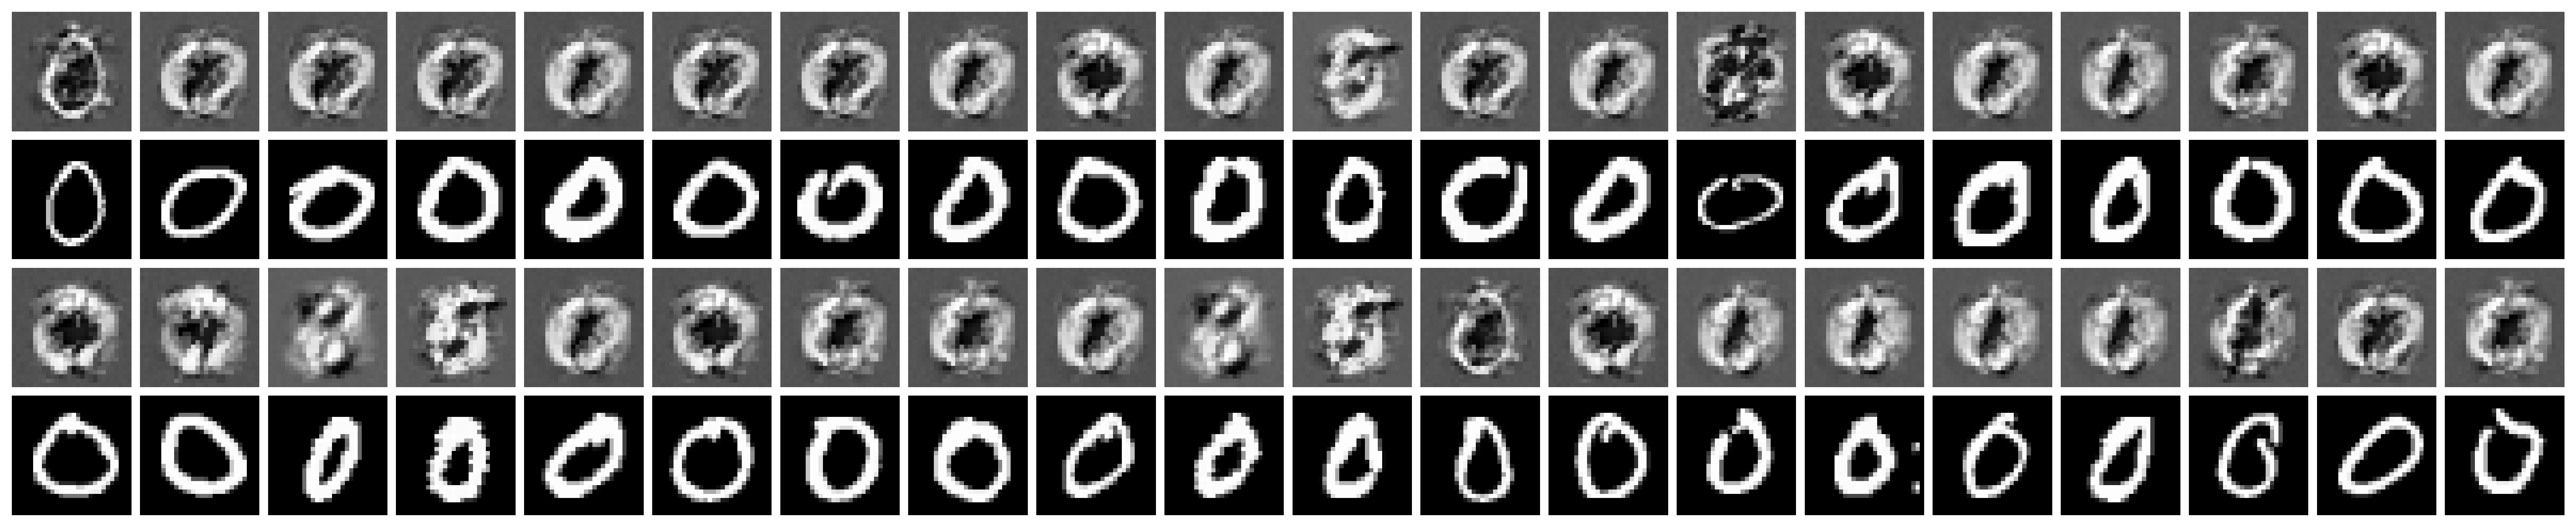

DONE!
tensor(515.6877, device='cuda:0', grad_fn=<SumBackward0>)


In [80]:
x_paths = [
    '/content/dataset_reconstruction/reconstructions/mnist_odd_even/rbijxft7_x.pth',
]
X = torch.load(x_paths[0])

# Find "Good" Reconstructions (as detailed in Appendix B.3) - DIGIT 0 ONLY:

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Filter for digit 0 only
# yy contains indices into Xtrn, we need to filter to keep only those that correspond to digit 0
# Align device
digit_0_indices = digit_0_indices.to(sort_idxs.device)

digit_0_in_Xtrn = torch.isin(sort_idxs, digit_0_indices)

xx = xx[digit_0_in_Xtrn]
yy = yy[digit_0_in_Xtrn]
ssims = ssims[digit_0_in_Xtrn]
sort_idxs = sort_idxs[digit_0_in_Xtrn]


print(f"Showing {len(xx)} reconstructions that match with digit 0 training samples")

values = model(Xtrn).data

# Plot
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=20, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)
print(torch.sum(model.layers[1].weight))

Showing 50 reconstructions that match with digit 0 training samples
CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([80, 1, 28, 28]) 4


  0%|          | 0/1 [00:00<?, ?it/s]

0 0 80


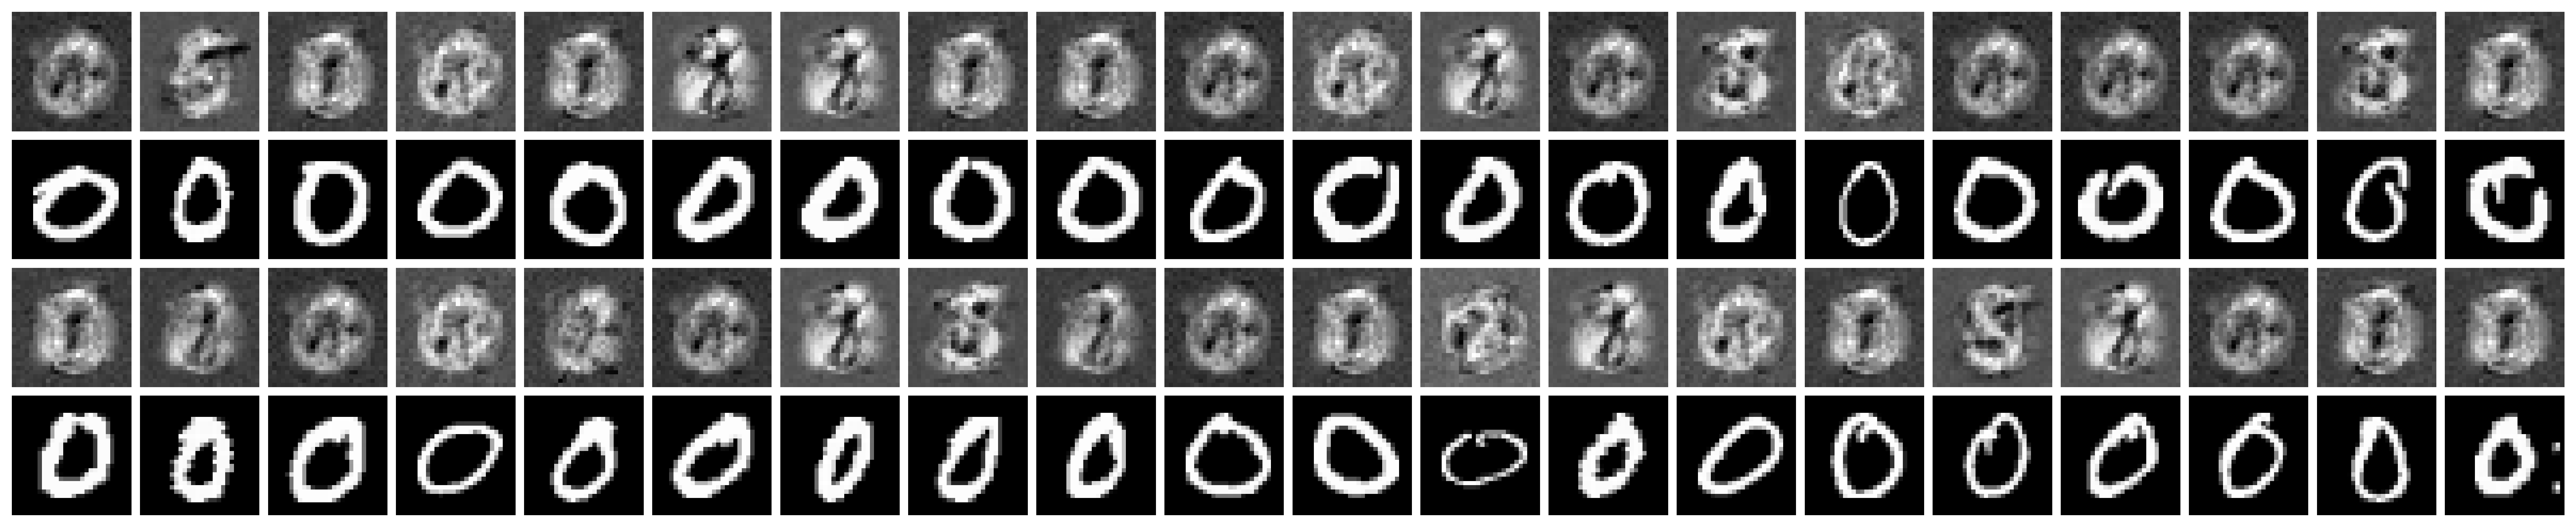

DONE!


In [81]:
x_paths = [
    '/content/dataset_reconstruction/reconstructions/mnist_odd_even/kcf9bhbi_x.pth',
]
X = torch.load(x_paths[0])

# Find "Good" Reconstructions (as detailed in Appendix B.3) - DIGIT 0 ONLY:

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Filter for digit 0 only
# yy contains indices into Xtrn, we need to filter to keep only those that correspond to digit 0
# Align device
digit_0_indices = digit_0_indices.to(sort_idxs.device)

digit_0_in_Xtrn = torch.isin(sort_idxs, digit_0_indices)

xx = xx[digit_0_in_Xtrn]
yy = yy[digit_0_in_Xtrn]
ssims = ssims[digit_0_in_Xtrn]
sort_idxs = sort_idxs[digit_0_in_Xtrn]


print(f"Showing {len(xx)} reconstructions that match with digit 0 training samples")

values = model(Xtrn).data

# Plot
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=20, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

Showing 50 reconstructions that match with digit 0 training samples
CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([80, 1, 28, 28]) 4


  0%|          | 0/1 [00:00<?, ?it/s]

0 0 80


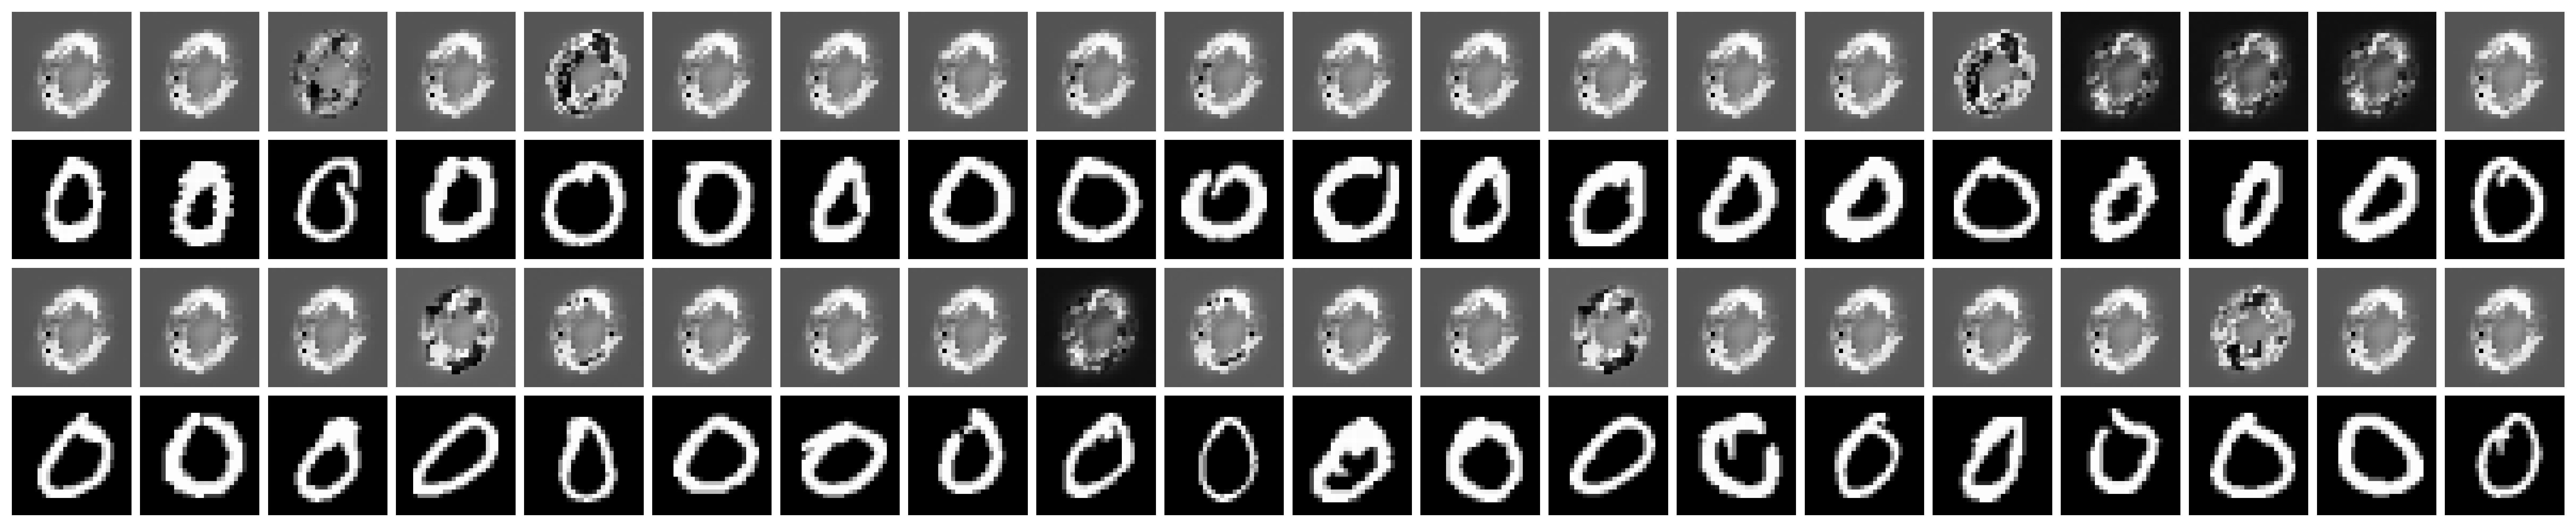

DONE!


In [104]:
x_paths = [
    '/content/dataset_reconstruction/runs/2026_02_13_23_08_43_991981_mnist_odd_even_d250/x/43000_x.pth',
]
X = torch.load(x_paths[0])

# Find "Good" Reconstructions (as detailed in Appendix B.3) - DIGIT 0 ONLY:

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')

# Filter for digit 0 only
# yy contains indices into Xtrn, we need to filter to keep only those that correspond to digit 0
# Align device
digit_0_indices = digit_0_indices.to(sort_idxs.device)

digit_0_in_Xtrn = torch.isin(sort_idxs, digit_0_indices)

xx = xx[digit_0_in_Xtrn]
yy = yy[digit_0_in_Xtrn]
ssims = ssims[digit_0_in_Xtrn]
sort_idxs = sort_idxs[digit_0_in_Xtrn]


print(f"Showing {len(xx)} reconstructions that match with digit 0 training samples")

values = model(Xtrn).data

# Plot
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=20, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

RECONSTRUCTION REPORT: DIGIT 0
Total Matches Found:      50
Unique Samples Recovered: 50
Redundancy Ratio:         1.00
------------------------------
Mean SSIM (All 50):       0.0408
Mean SSIM (Top 5):        0.0514

Visualizing Top 5 Reconstructions (Best to Worst):


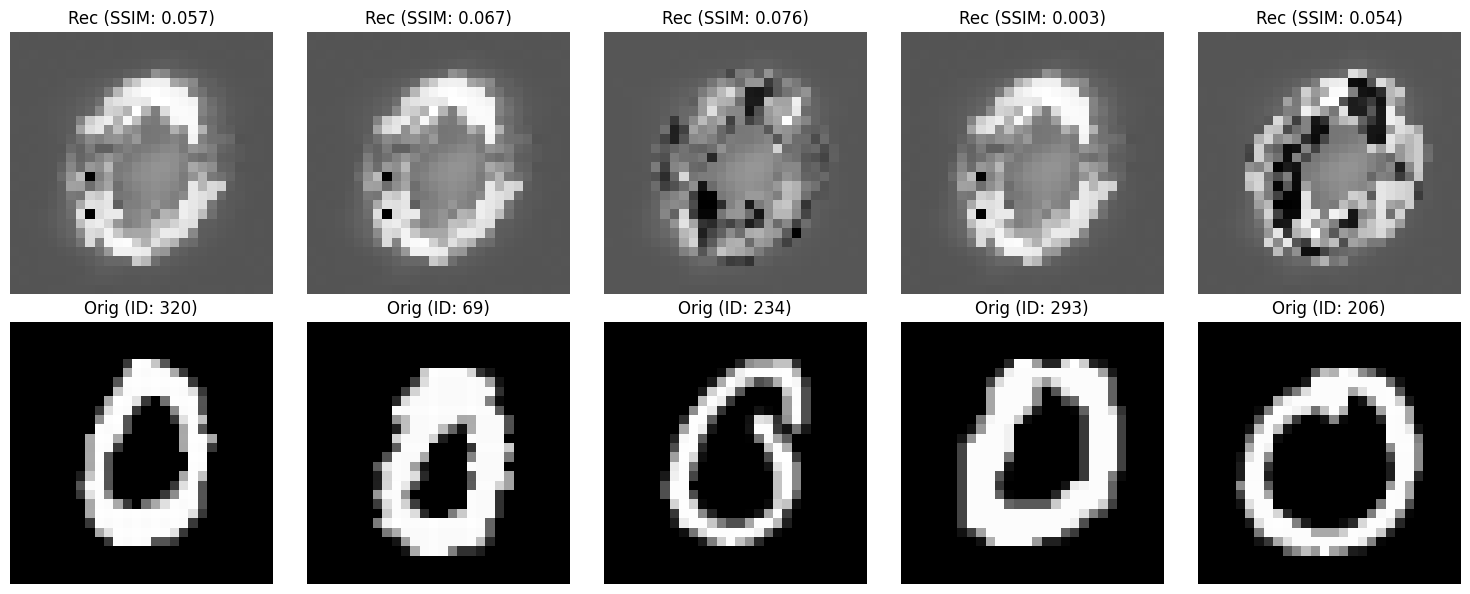

In [105]:
import torch
import matplotlib.pyplot as plt

# 1. Basic Counts
total_filtered = len(xx)
unique_indices = torch.unique(sort_idxs)
unique_count = len(unique_indices)
redundancy = total_filtered / unique_count if unique_count > 0 else 0

# 2. SSIM Metrics
# Since sort_by_metric was called with sort='ssim',
# the tensors are already ordered from highest SSIM to lowest.
mean_ssim_all = ssims.mean().item()
top_5_ssim = ssims[:5].mean().item()

# 3. Print the Report
print("="*30)
print("RECONSTRUCTION REPORT: DIGIT 0")
print("="*30)
print(f"Total Matches Found:      {total_filtered}")
print(f"Unique Samples Recovered: {unique_count}")
print(f"Redundancy Ratio:         {redundancy:.2f}")
print("-" * 30)
print(f"Mean SSIM (All 50):       {mean_ssim_all:.4f}")
print(f"Mean SSIM (Top 5):        {top_5_ssim:.4f}")
print("="*30)

# 4. Plotting the Top 5 specifically
print("\nVisualizing Top 5 Reconstructions (Best to Worst):")
plt.figure(figsize=(15, 6))
for i in range(5):
    # Top Row: Reconstructed
    plt.subplot(2, 5, i + 1)
    plt.imshow(xx[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Rec (SSIM: {ssims[i]:.3f})")
    plt.axis('off')

    # Bottom Row: Original Training Match
    plt.subplot(2, 5, i + 6)
    plt.imshow(yy[i].detach().cpu().squeeze(), cmap='gray')
    plt.title(f"Orig (ID: {sort_idxs[i].item()})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [106]:
from torch.nn.functional import cosine_similarity

# Flatten images to compare them
flat_xx = xx.view(len(xx), -1)

# Compare the first image to all others
sim_to_first = cosine_similarity(flat_xx[0:1], flat_xx)

# Count how many images are > 95% identical to the first one
visually_identical = torch.sum(sim_to_first > 0.95).item()

print(f"Visual Analysis:")
print(f"Out of {len(xx)} images, {visually_identical} look almost identical to the first one.")

Visual Analysis:
Out of 50 images, 32 look almost identical to the first one.
